In [1]:
from fastai.vision import *
import fastai
fastai.__version__

'1.0.61'

In [2]:
# ??Module

In [3]:
# import shutil
# shutil.rmtree(''../output')

In [4]:
# !pip install --upgrade pip

In [5]:
# !pip install --upgrade fastai

In [6]:
# !pip install --upgrade torch

In [7]:
import torch
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [8]:
# torch.cuda.empty_cache()

In [9]:
torch.cuda.memory_allocated()

0

> ***BIO MEDICAL IMAGE SEGMENTATION***

In [10]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# %load_ext tensorboard
%load_ext tensorboard

In [11]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.callbacks.tensorboard import*

In [12]:
import os
print(os.listdir("../input"))

['warwickquchangeddataset', 'warwick-qu-dataset', 'p-1-dataset']


In [13]:
path = pathlib.Path("../input/warwickquchangeddataset/changes_data")
path.ls()

[PosixPath('../input/warwickquchangeddataset/changes_data/valid'),
 PosixPath('../input/warwickquchangeddataset/changes_data/train_gt'),
 PosixPath('../input/warwickquchangeddataset/changes_data/train'),
 PosixPath('../input/warwickquchangeddataset/changes_data/valid_gt')]

In [14]:
path_trn_lbl = path/'train_gt'
path_trn = path/'train'
path_valid_lbl = path/'valid_gt'
path_valid = path/'valid'

1. # >  Classes **Main code**


In [15]:
from fastai.vision.learner import*
from fastai.layers import *
# import fastai

In [16]:
def conv_norm_relu_sa(ni:int, nf:int, ks:int=3, stride:int=1, padding:int=None, bias:bool=None, is_1d:bool=False,
               norm_type:Optional[NormType]=NormType.Batch,  use_activ:bool=True, leaky:float=None,
               transpose:bool=False, init:Callable=nn.init.kaiming_normal_, self_attention:bool=False):
    if padding is None: padding = (ks-1)//2 if not transpose else 0
    bn = norm_type in (NormType.Batch, NormType.BatchZero)
    if bias is None: bias = not bn
    conv_func = nn.ConvTranspose2d if transpose else nn.Conv1d if is_1d else nn.Conv2d
    conv = init_default(conv_func(ni, nf, kernel_size=ks, bias=bias, stride=stride, padding=padding), init)
    if   norm_type==NormType.Weight:   conv = weight_norm(conv)
    elif norm_type==NormType.Spectral: conv = spectral_norm(conv)
    layers = [conv]
    if use_activ: layers.append(relu(True, leaky=leaky))
    if bn: layers.append((nn.BatchNorm1d if is_1d else nn.BatchNorm2d)(nf))
    if self_attention: layers.append(SelfAttention(nf))
    return nn.Sequential(*layers)

In [17]:
# ??Module

In [18]:
from fastai.callbacks.hooks import *

In [19]:

def indx_where_sz_changes(sizes:Sizes) -> List[int]:
#      Here when the size of feature map changes during encoder their previous module indexs are noted
#      Input is Sizes from encoder part
    feature_szs = [size[-1] for size in sizes]
    sfs_idxs = list(np.where(np.array(feature_szs[:-1]) != np.array(feature_szs[1:]))[0])
    if feature_szs[0] != feature_szs[1]: sfs_idxs = [0] + sfs_idxs
    return sfs_idxs

In [20]:

class Unet_block_clss(Module):
    def __init__(self, up_in_c:int, x_in_c:int, hook:Hook, final_div:bool=True, blur:bool=False, leaky:float=None,
                 self_attention:bool=False, **kwargs):
#         From encoder part activations are taken from hooks() and are concatenated to decoder activations
        self.hook = hook
        self.shuf = PixelShuffle_ICNR(up_in_c, up_in_c//2, blur=blur, leaky=leaky, **kwargs)
        self.bn = batchnorm_2d(x_in_c)
        ni = up_in_c//2 + x_in_c
        nf = ni if final_div else ni//2
        self.conv1 = conv_norm_relu_sa(ni, nf, leaky=leaky, **kwargs)
        self.conv2 = conv_norm_relu_sa(nf, nf, leaky=leaky, self_attention=self_attention, **kwargs)
        self.relu = relu(leaky=leaky)

    def forward(self, up_in:Tensor) -> Tensor:
        s = self.hook.stored
        up_out = self.shuf(up_in)
        ssh = s.shape[-2:]
#         If sizes are not equal interpolation is done velow
        if ssh != up_out.shape[-2:]:
            up_out = F.interpolate(up_out, s.shape[-2:], mode='nearest')
        cat_x = self.relu(torch.cat([up_out, self.bn(s)], dim=1))
        return self.conv2(self.conv1(cat_x))



In [21]:
class Decoder_clss(SequentialEx):
    def __init__(self, encoder:nn.Module, n_classes:int, img_size:Tuple[int,int]=(256,256), blur:bool=False, blur_final=True, self_attention:bool=False,
                 y_range:Optional[Tuple[float,float]]=None,
                 last_cross:bool=True, bottle:bool=False, **kwargs):
        imsize = img_size
#         Encoder part sizes
        sfs_szs = model_sizes(encoder, size=imsize)
        sfs_idxs = list(reversed(indx_where_sz_changes(sfs_szs)))
#         Storing hooks for every layer in sfs_idxs
        self.sfs = hook_outputs([encoder[i] for i in sfs_idxs], detach=False)
#         In the whole code x is used to help with size and channels
        x = dummy_eval(encoder, imsize).detach()

        ni = sfs_szs[-1][1]
        middle_conv = nn.Sequential(conv_norm_relu_sa(ni, ni*2, **kwargs),
                                    conv_norm_relu_sa(ni*2, ni, **kwargs)).eval()
        x = middle_conv(x)
        layers = [encoder, batchnorm_2d(ni), nn.ReLU(), middle_conv]

        for i,idx in enumerate(sfs_idxs):
            not_final = i!=len(sfs_idxs)-1
            up_in_c, x_in_c = int(x.shape[1]), int(sfs_szs[idx][1])
            do_blur = blur and (not_final or blur_final)
            sa = self_attention and (i==len(sfs_idxs)-3)
            unet_block = Unet_block_clss(up_in_c, x_in_c, self.sfs[i], final_div=not_final, blur=do_blur, self_attention=sa,
                                   **kwargs).eval()
            layers.append(unet_block)
            x = unet_block(x)

        ni = x.shape[1]
        if imsize != sfs_szs[0][-2:]: layers.append(PixelShuffle_ICNR(ni, **kwargs))
        x = PixelShuffle_ICNR(ni)(x)
        if imsize != x.shape[-2:]: layers.append(Lambda(lambda x: F.interpolate(x, imsize, mode='nearest')))
        if last_cross:
            layers.append(MergeLayer(dense=True))
            ni += in_channels(encoder)
            layers.append(res_block(ni, bottle=bottle, **kwargs))
        layers += [conv_norm_relu_sa(ni, n_classes, ks=1, use_activ=False, **kwargs)]
#         if y_range is not None: layers.append(SigmoidRange(*y_range))
        super().__init__(*layers)
# Removing hooks when exiting with as loop
    def __del__(self):
        if hasattr(self, "sfs"): self.sfs.remove()

In [22]:
def _default_split(m:nn.Module): return (m[1],)
# Split a resnet style model
def _resnet_split(m:nn.Module): return (m[0][6],m[1])
def _vgg_split(m:nn.Module): return (m[0][0][22],m[1])

_default_meta     = {'cut':None, 'split':_default_split}
_resnet_meta      = {'cut':-2, 'split':_resnet_split }
_vgg_meta         = {'cut':-1, 'split':_vgg_split}

model_meta = {
    models.resnet18 :{**_resnet_meta}, models.resnet34: {**_resnet_meta},
    models.resnet50 :{**_resnet_meta}, models.resnet101:{**_resnet_meta},
    models.resnet152:{**_resnet_meta},
#     models.vgg11_bn:{**_vgg_meta}, models.vgg13_bn:{**_vgg_meta}, models.vgg16_bn:{**_vgg_meta}, models.vgg19_bn:{**_vgg_meta},

}

def cnn_config(arch):
    "Get the metadata associated with `arch`."
    torch.backends.cudnn.benchmark = True
    return model_meta.get(arch, _default_meta)

In [23]:
def learner_unet(data:DataBunch, arch:Callable, pretrained:bool=True, blur_final:bool=True,
                 norm_type:Optional[NormType]=None, split_on:Optional[SplitFuncOrIdxList]=None, blur:bool=False,
                 self_attention:bool=False, y_range:Optional[Tuple[float,float]]=None, last_cross:bool=True,
                 bottle:bool=False, cut:Union[int,Callable]=None, **learn_kwargs:Any)->Learner:
    "Build Unet learner from `data` and `arch`."
    meta = cnn_config(arch)
    body = create_body(arch, pretrained, cut)
    try:    size = data.train_ds[0][0].size
    except: size = next(iter(data.train_dl))[0].shape[-2:]
    model = to_device(Decoder_clss(body, n_classes=data.c, img_size=size, blur=blur, blur_final=blur_final,
          self_attention=self_attention, y_range=y_range, norm_type=norm_type, last_cross=last_cross,
          bottle=bottle), data.device)
    learn = Learner(data, model, **learn_kwargs)
    learn.split(ifnone(split_on, meta['split']))
    if pretrained: learn.freeze()
    apply_init(model[2], nn.init.kaiming_normal_)
    return learn

## Data

In [24]:
fnames = get_image_files(path_trn)
fnames[:6]

[PosixPath('../input/warwickquchangeddataset/changes_data/train/train_84.bmp'),
 PosixPath('../input/warwickquchangeddataset/changes_data/train/train_10.bmp'),
 PosixPath('../input/warwickquchangeddataset/changes_data/train/train_4.bmp'),
 PosixPath('../input/warwickquchangeddataset/changes_data/train/train_46.bmp'),
 PosixPath('../input/warwickquchangeddataset/changes_data/train/train_41.bmp'),
 PosixPath('../input/warwickquchangeddataset/changes_data/train/train_47.bmp')]

In [25]:
lbl_names = get_image_files(path_trn_lbl)
lbl_names[:6]

[PosixPath('../input/warwickquchangeddataset/changes_data/train_gt/train_42_annot.bmp'),
 PosixPath('../input/warwickquchangeddataset/changes_data/train_gt/train_53_annot.bmp'),
 PosixPath('../input/warwickquchangeddataset/changes_data/train_gt/train_79_annot.bmp'),
 PosixPath('../input/warwickquchangeddataset/changes_data/train_gt/train_68_annot.bmp'),
 PosixPath('../input/warwickquchangeddataset/changes_data/train_gt/train_83_annot.bmp'),
 PosixPath('../input/warwickquchangeddataset/changes_data/train_gt/train_24_annot.bmp')]

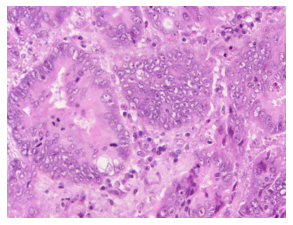

In [26]:
img_f = fnames[4]
img = open_image(img_f)
img.show(figsize=(5,5))

In [27]:
img_f.stem[0:5]


'train'

In [28]:
get_y_fn = lambda x: (path_trn_lbl/f'{x.stem}_annot.bmp' if (x.stem[0:5] == 'train') else path_valid_lbl/f'{x.stem}_annot.bmp')

In [29]:
get_y_fn(img_f)

PosixPath('../input/warwickquchangeddataset/changes_data/train_gt/train_41_annot.bmp')

In [30]:
maskk = [open_mask(get_y_fn(img_f)) for img_f in fnames]
# len(mask)
sett = set()
for i in range(85):
    sett = sett.union(set(np.unique(maskk[i].data)))

# mask.show(figsize=(5,5), alpha=1)

In [31]:
# print(sett)
print(len(sett))

2


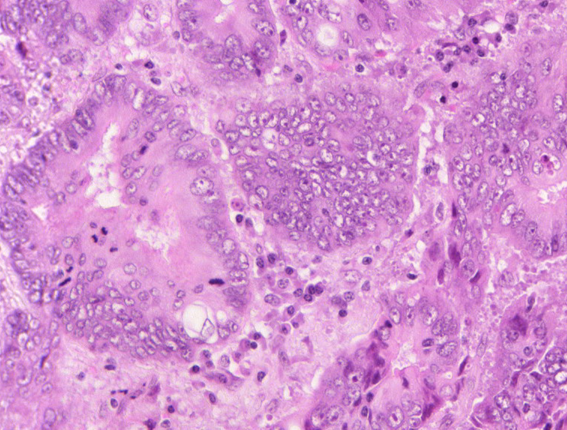

In [32]:
# len(np.unique(mask.data))
open_image(img_f)

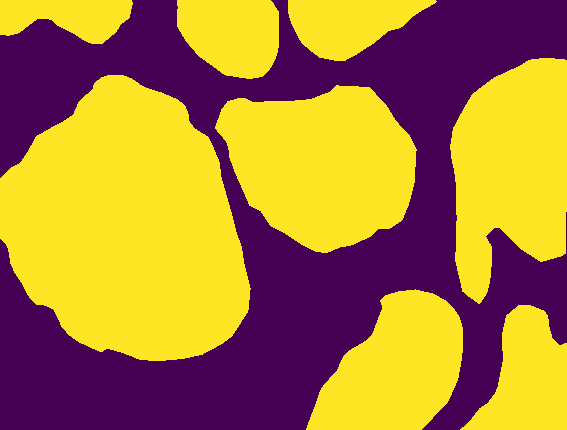

In [33]:
mask = open_mask(get_y_fn(img_f))
mask

In [34]:
src_size = np.array(mask.shape[1:])
src_size,print(mask.data)

tensor([[[255, 255, 255,  ...,   0,   0,   0],
         [255, 255, 255,  ...,   0,   0,   0],
         [255, 255, 255,  ...,   0,   0,   0],
         ...,
         [  0,   0,   0,  ..., 255, 255, 255],
         [  0,   0,   0,  ..., 255, 255, 255],
         [  0,   0,   0,  ..., 255, 255, 255]]])


(array([430, 567]), None)

In [ ]:
ff = mask.data
# ff[ff>1] = 1.
# ff[ff<=1] = 0.
ff[-1][-1]

In [ ]:
# torch.set_printoptions(profile="full")
# print(mask.data)
# torch.set_printoptions(profile="default")

In [ ]:
np.unique(mask.data)

In [35]:
# codes = np.loadtxt(pa/'codes.txt', dtype=str);
codes = ['yes' for i in range(256)]
# codes = ['yes', 'no']

In [36]:
len(codes)

256

In [42]:
src_size = (512,512)

## Datasets

In [62]:
size = src_size
bs=4
print(size)

(512, 512)


In [63]:
src = (SegmentationItemList.from_folder(path)
       .split_by_folder(train='train', valid='valid')
        .label_from_func(get_y_fn,classes = codes))
src

LabelLists;

Train: LabelList (85 items)
x: SegmentationItemList
Image (3, 453, 589),Image (3, 522, 775),Image (3, 522, 775),Image (3, 522, 775),Image (3, 430, 567)
y: SegmentationLabelList
ImageSegment (1, 453, 589),ImageSegment (1, 522, 775),ImageSegment (1, 522, 775),ImageSegment (1, 522, 775),ImageSegment (1, 430, 567)
Path: ../input/warwickquchangeddataset/changes_data;

Valid: LabelList (60 items)
x: SegmentationItemList
Image (3, 522, 775),Image (3, 522, 775),Image (3, 522, 775),Image (3, 522, 775),Image (3, 522, 775)
y: SegmentationLabelList
ImageSegment (1, 522, 775),ImageSegment (1, 522, 775),ImageSegment (1, 522, 775),ImageSegment (1, 522, 775),ImageSegment (1, 522, 775)
Path: ../input/warwickquchangeddataset/changes_data;

Test: None

In [64]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs, num_workers=0)
        .normalize(imagenet_stats))
data

ImageDataBunch;

Train: LabelList (85 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: ../input/warwickquchangeddataset/changes_data;

Valid: LabelList (60 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: ../input/warwickquchangeddataset/changes_data;

Test: None

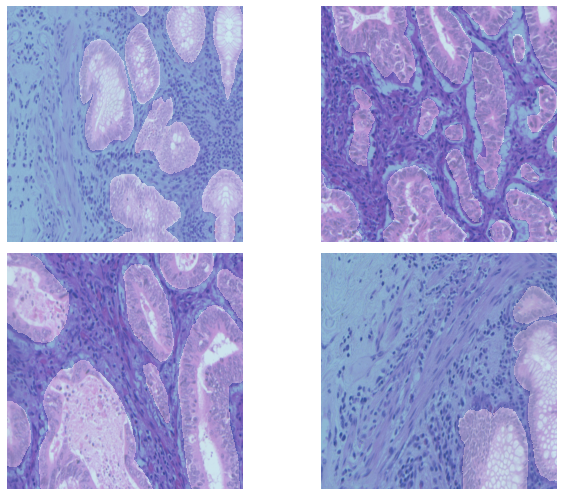

In [65]:
data.show_batch(2, figsize=(10,7))

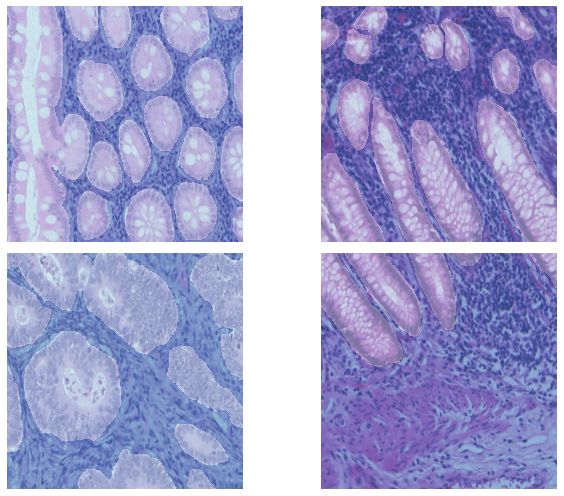

In [66]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [67]:
name2id = {v:k for k,v in enumerate(codes)}
# void_code = name2id['Void']

def my_acc_changed(input, target):
#     print("inputsize = ",input.size(),"\n tar_size = ",target.size())
    target = target.squeeze(1)
    target1 = target
    target1[target1>0] = 1.
    input1 = input.argmax(dim=1)
    input1[input1>0] = 1.
#     mask = target != void_code
    return (input1==target1).float().mean()

def my_acc(input, target):
#     print("inputsize = ",input.size(),"\n tar_size = ",target.size())
    target = target.squeeze(1)
#     mask = target != void_code
    return (input.argmax(dim=1)==target).float().mean()

In [68]:
def my_dice(input:Tensor, targs:Tensor, iou:bool=False, eps:float=1e-8)->Rank0Tensor:
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
    n = targs.shape[0]
    targs = targs.squeeze(1)
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    targs1 = (targs>0).float()
    input1 = (input>0).float()
    ss = (input == targs).float()
    intersect = (ss * targs1).sum(dim=1).float()
    union = (input1+targs1).sum(dim=1).float()
    if not iou: l = 2. * intersect / union
    else: l = intersect / (union-intersect+eps)
    l[union == 0.] = 1.
    return l.mean()

In [69]:
# def mydice_(input:Tensor, targs:Tensor, iou:bool=True, eps:float=1e-8)->Rank0Tensor:
#     n = targs.shape[0]
#     dice_sum = torch.as_tensor([0.], dtype=torch.float32, device=targs.device)
#     for i in range(1, targs.max()+1):
#         input_flatten = input[:,i-1,:,:].flatten(1,-1).float()
#         targs_flatten = targs.flatten(1,-1).float()
#         input_flatten[input_flatten>0.5], input_flatten[input_flatten<=0.5] = 1., 0.
#         targs_flatten[targs_flatten!=i], targs_flatten[targs_flatten==i] = 0, 1
#         intersect = (input_flatten * targs_flatten).sum(dim=1)
#         union = (input_flatten + targs_flatten).sum(dim=1)
#         if not iou: l = 2. * intersect / union
#         else: l = intersect / (union-intersect+eps)
#         l[union == 0.] = 1
#         dice_sum += l.mean()
#     return dice_sum / targs.max()

In [70]:
metrics=[partial(my_dice,iou = False),my_acc]
# metrics=accuracy
# metrics=acc_camvid

In [71]:
wd=1e-2

In [72]:
# learn.destroy()
# gc.collect()

In [80]:
learn = learner_unet(data, models.resnet34, metrics=metrics,callback_fns=[ActivationStats], wd=wd,path = ".", model_dir="")

In [74]:
# from tensorboardX import SummaryWriter
# from fastai.callback import Callback
# from pathlib import Path
# import shutil


# class TensorboardLogger1(Callback):
#     """
#     A general Purpose Logger for TensorboardX
#     Also save a .txt file for the important parts
#     """

#     def __init__(self, learner, log_name, del_existing=False, histogram_freq=100):
#         """
#         Learner is the ConvLearner
#         log_name: name of the log directory to be formed. Will be input
#         for each run
#         cfgtxt: HyperParams
#         del_existing: To run the experiment from scratch and remove previous logs
#         """
#         super().__init__()
#         self.learn = learner
#         self.model = learner.model
#         self.md = learner.data

#         self.metrics_names = ["validation_loss"]
#         self.metrics_names += [m.__name__ for m in learner.metrics]

#         self.best_met = 0

#         self.histogram_freq = histogram_freq

#         path = Path(self.md.path) / "logs"
#         self.log_name = log_name
#         self.log_dir = path / log_name

#         self.init_logs(self.log_dir, del_existing)
#         self.init_tb_writer()

#     def init_logs(self, log_dir, del_existing):
#         if log_dir.exists():
#             if del_existing:
#                 print(f'removing existing log with same name {log_dir.stem}')
#                 shutil.rmtree(self.log_dir)

#     def init_tb_writer(self):
#         self.writer = SummaryWriter(
#             comment='main_mdl', log_dir=str(self.log_dir))
#         self.writer.add_text('HyperParams', self.cfgtxt)


#     def on_batch_end(self, **kwargs):
#         self.trn_loss = kwargs['last_loss']
#         num_batch = kwargs['num_batch']
#         self.writer.add_scalar(
#             'trn_loss_batch', self.trn_loss, num_batch)

#     def on_epoch_end(self, **kwargs):
#         metrics = kwargs['last_metrics']
#         epoch = kwargs['epoch']
#         trn_loss = kwargs['smooth_loss']
#         self.writer.add_scalar('trn_loss', trn_loss, epoch)

#         for val, name in zip(metrics, self.metrics_names):
#             self.writer.add_scalar(name, val, epoch)

#         self.file_write(self.str_form.format(epoch,
#                                              self.trn_loss, *metrics))

#         m = metrics[1]
#         if m > self.best_met:
#             self.best_met = m
#             self.learn.save(self.log_name)

#     def on_train_end(self, **kwargs):
#         self.writer.add_text('Total Epochs', str(kwargs['epoch']))
#         self.writer.close()
#         self.file_write(f'Epochs done, {kwargs["epoch"]}')

#     def file_write(self, outstr):
#         with open(self.fw_, 'a') as f:
#             f.write(outstr)

In [75]:
# from tensorboard import *
# writer = SummaryWriter(comment='Demo')
# mycallback = partial(TensorBoardFastAI, writer, track_weight=True, track_grad=True, metric_names=['val loss','dicee', 'accuracy'])
# learn.callback_fns.append(mycallback)

In [ ]:
from fastai.callbacks.tensorboard import*

In [ ]:
# Tensorboard Integration
project_id = 'ProjectP_1'
# del_existing = True
tboard_path = Path('data/tmp/tensorboard/' + project_id)
tb_calb = LearnerTensorboardWriter(learn,tboard_path,name='tb_1',loss_iters=1,hist_iters=10,stats_iters=10)
# tb_calb2 = TensorboardLogger1(learn,'tb_n',del_existing=del_existing) #TensorBoardLogger1 Class is in above cells
# tb_calb1 = partial(LearnerTensorboardWriter,base_dir=tboard_path,name='tb_1',loss_iters=1,hist_iters=10,stats_iters=10)
# learn.callback_fns.append(tb_calb1)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


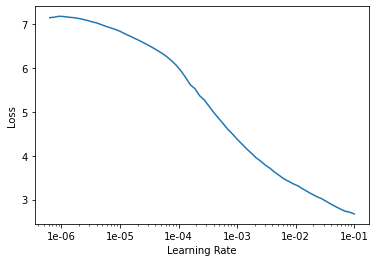

In [56]:
lr_find(learn)
learn.recorder.plot()

In [81]:
lr=6e-4

In [82]:
learn.fit_one_cycle(50, slice(lr), pct_start=0.3)

epoch,train_loss,valid_loss,my_dice,my_acc,time
0,2.592335,1.313381,0.095876,0.501146,00:23
1,1.561479,0.819113,0.648587,0.554937,00:23
2,1.151163,0.622113,0.652725,0.684121,00:23
3,0.909205,0.466463,0.752626,0.790209,00:23
4,0.741706,0.456414,0.771634,0.793708,00:23
5,0.658178,0.618646,0.528618,0.672664,00:23
6,0.599220,0.437910,0.817843,0.820894,00:23
7,0.515297,0.368805,0.822246,0.844712,00:23
8,0.518789,0.349211,0.825800,0.848334,00:23
9,0.507438,0.559643,0.778084,0.758841,00:23


In [ ]:
!tensorboard --logdir=data/tmp/tensorboard/ProjectP_1/tb_1
# %tensorboard --logdir=$tboard_path --port=6006

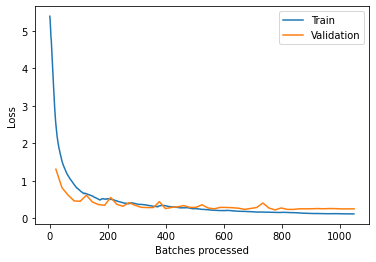

In [83]:
learn.recorder.plot_losses()

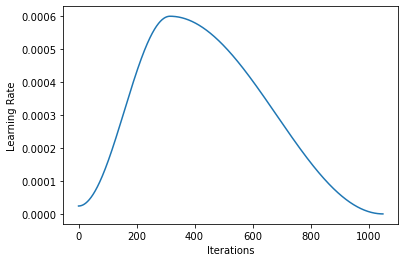

In [84]:
learn.recorder.plot_lr()

In [85]:
learn.save('stage-1')

In [86]:
learn.load('stage-1');

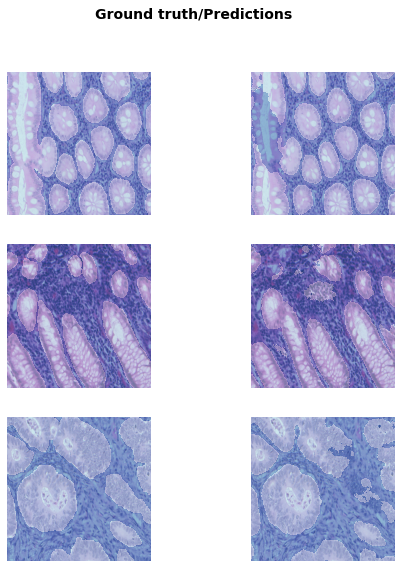

In [87]:
learn.show_results(rows=3, figsize=(8,9))

In [ ]:
# x1 = learn.data.train_ds[0][0]
# show_image(x1)

# show_image(learn.predict(x1)[0])

# show_image(learn.predict(x1)[1])

# show_image(learn.predict(x1)[0])

In [ ]:


# img = learn.data.train_ds[0][0]
# fig=plt.figure(figsize=(16, 16))
# rows = 2; columns = 2
# fig.add_subplot(rows, columns, 1)
# plt.imshow(img)
# for i in range(3):
#     fig.add_subplot(rows, columns, i+2)
#     plt.imshow(learn.predict(img)[i])
# plt.show()
    


In [88]:
learn.unfreeze()

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [89]:
lrs = slice(lr/500,lr/5)

In [90]:
learn.fit_one_cycle(50, lrs, pct_start=0.3)

epoch,train_loss,valid_loss,my_dice,my_acc,time
0,0.116203,0.248581,0.904016,0.911813,00:24
1,0.115699,0.253420,0.904603,0.911991,00:23
2,0.117073,0.256780,0.904786,0.911906,00:24
3,0.116923,0.254212,0.903697,0.911354,00:23
4,0.118846,0.254873,0.905646,0.913706,00:23
5,0.119532,0.258121,0.901341,0.909720,00:24
6,0.121306,0.241154,0.905529,0.914476,00:24
7,0.119980,0.249000,0.903523,0.911209,00:23
8,0.117312,0.257119,0.905500,0.912387,00:23
9,0.119745,0.230243,0.909086,0.916977,00:23


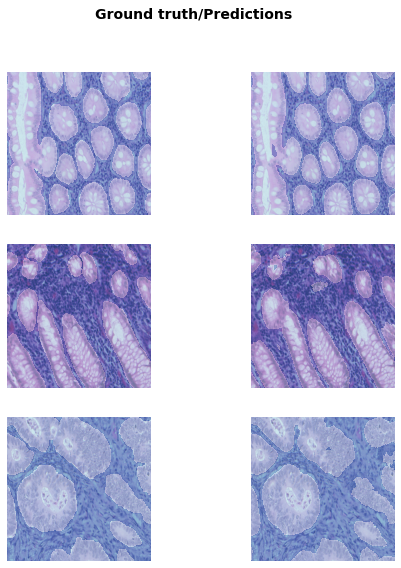

In [93]:
learn.show_results(rows=3, figsize=(8,9))

In [94]:
learn.save('stage-2');

## Go big

If out of CUDA memory restart kernel

In [ ]:
# torch.cuda.empty_cache()

In [ ]:
# # learn.destroy()
# gc.collect()

In [ ]:
from fastai.utils.mem import *

In [ ]:
size = src_size
print(size)
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=4
else:           bs=2
print(f"using bs={bs}, have {free}MB of GPU RAM free")


In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, model_dir="/tmp/model/")

In [ ]:
learn.load('stage-2');

In [ ]:
learn.callback_fns.append(partial(LearnerTensorboardWriter, 
                                    base_dir=tboard_path, 
                                    name='tb_2'))

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-4

In [ ]:
learn.fit_one_cycle(50, slice(lr), pct_start=0.8)

In [ ]:
tensorboard --logdir=data/tensorboard/project_id/tb_2

In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lrs = slice(1e-5,lr/1)

In [ ]:
learn.fit_one_cycle(20, lrs)

In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

In [ ]:
learn.show_results(rows=3, figsize=(10,10))

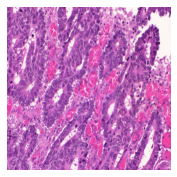

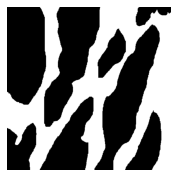

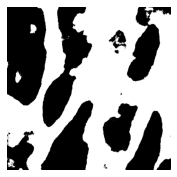

In [97]:
x1 = learn.data.valid_ds[3]
show_image(x1[0])
show_image(x1[1])
show_image(learn.predict(x1[0])[1])

In [ ]:
x1[1].data
learn.predict(x1[0])[1]

In [ ]:
x1 = learn.data.valid_ds[3]
show_image(x1[0])
show_image(x1[1])
show_image(learn.predict(x1[0])[1])

**Research**

In [ ]:
from fastai.vision.models.unet import *

In [ ]:
import torch
import torch.nn as nn

In [ ]:
from fastai.torch_core import *
from fastai.layers import *
from fastai.callbacks.hooks import *

In [ ]:
UnetBlock??

In [ ]:
class UnetBlock1(nn.Module):
    "A quasi-UNet block, using `PixelShuffle_ICNR upsampling`."
    def __init__(self, up_in_c:int, x_in_c:int, hook:Hook, final_div:bool=True, blur:bool=False, leaky:float=None,
                 self_attention:bool=False, **kwargs):
        self.hook = hook
        self.shuf = PixelShuffle_ICNR(up_in_c, up_in_c//2, blur=blur, leaky=leaky, **kwargs)
        self.bn = batchnorm_2d(x_in_c)
        ni = up_in_c//2 + x_in_c
        nf = ni if final_div else ni//2
        self.conv1 = conv_layer(ni, nf, leaky=leaky, **kwargs)
        self.conv2 = conv_layer(nf, nf, leaky=leaky, self_attention=self_attention, **kwargs)
        self.relu = relu(leaky=leaky)

    def forward(self, up_in:Tensor) -> Tensor:
        s = self.hook.stored
        up_out = self.shuf(up_in)
        ssh = s.shape[-2:]
        if ssh != up_out.shape[-2:]:
            up_out = F.interpolate(up_out, s.shape[-2:], mode='nearest')
        cat_x = self.relu(torch.cat([up_out, self.bn(s)], dim=1))
        return x + self.conv2(self.conv1(cat_x))